In [1]:
import pandas as pd

od_foldername = "/home/anca/Documents/Open-Domain-Relation-Extraction/data/crowdsourcing/stanford_crowdsourcing/input/"

import sys
stdout = sys.stdout

sys.path.append('../../')

from defaultconfig import Configuration

class ODRelExConfig(Configuration):
    inputColumns = ["Input.sent_id", "Input.relation", "Input.confidence", "Input.term1", "Input.b1", "Input.e1",
                    "Input.term2", "Input.b2", "Input.e2", "Input.sentence"]
    outputColumns = ["Answer.Q1"]
    open_ended_task = False
    annotation_vector = ["per:title", "per:founded_org", "per:place_of_birth", "per:children", "per:cause_of_death",
                         "per:top_member_employee_of_org", "per:employee_or_member_of", "per:spouse",
                         "org:alternate_names", "org:subsidiaries", "per:place_of_death", "per:schools_attended",
                         "org:place_of_headquarters", "per:charges", "per:origin", "per:places_of_residence", "none"]
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('|',','))
            
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:age,',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(',per:age',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:age','none'))
            
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:alternate_names','org:alternate_names'))
            judgments[col] = judgments[col].apply(lambda x: ','.join(sorted(str(x).split(','))))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(
                'org:alternate_names,org:alternate_names','org:alternate_names'))
        return judgments

config = ODRelExConfig()

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory=od_foldername, filename="",
    config=config
)

In [2]:
sys.stdout = stdout

# run the metrics
from models import Metrics
processed_results = Metrics.run(pre_processed_results, config)

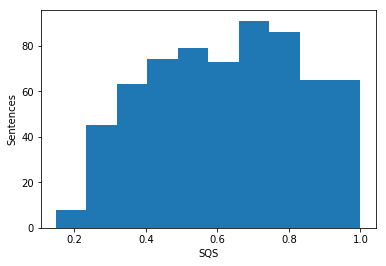

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(processed_results["units"]["uqs"])
plt.xlabel("SQS")
plt.ylabel("Sentences")

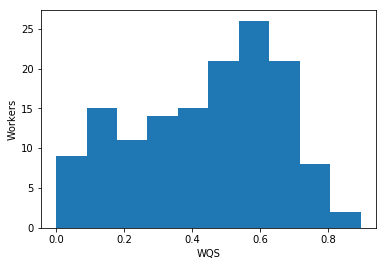

In [4]:
plt.hist(processed_results["workers"]["wqs"])
plt.xlabel("WQS")
plt.ylabel("Workers")

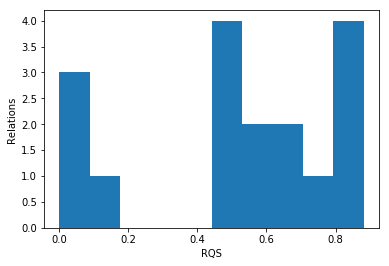

In [5]:
plt.hist(processed_results["annotations"]["aqs"])
plt.xlabel("RQS")
plt.ylabel("Relations")

In [6]:
processed_results["annotations"]["aqs"]

none                              0.464663
org:alternate_names               0.577163
org:place_of_headquarters         0.805961
org:subsidiaries                  0.756364
per:cause_of_death                0.007481
per:charges                       0.015686
per:children                      0.001097
per:employee_or_member_of         0.605772
per:founded_org                   0.798146
per:origin                        0.444798
per:place_of_birth                0.663091
per:place_of_death                0.881756
per:places_of_residence           0.525680
per:schools_attended              0.142410
per:spouse                        0.874605
per:title                         0.495591
per:top_member_employee_of_org    0.685326
Name: aqs, dtype: float64

In [7]:
import operator

dlist = []
max_frame = []
max_fss = []
for idx in processed_results["units"].index:
    if idx != "unit_annotation_score":
        aux_dict = { k:v for k, v in processed_results["units"]["unit_annotation_score"][idx].iteritems() if v }
        dlist.append(aux_dict)
        max_frame.append(max(aux_dict.iteritems(), key=operator.itemgetter(1))[0])
        max_fss.append(max(aux_dict.values()))

processed_results["units"]["SRS"] = pd.Series(dlist, index=processed_results["units"].index)
processed_results["units"]["max_rel"] = pd.Series(max_frame, index=processed_results["units"].index)
processed_results["units"]["max_srs"] = pd.Series(max_fss, index=processed_results["units"].index)

processed_results["units"].to_csv("amt_od_relex_sentences.csv")
processed_results["workers"].to_csv("amt_od_relex_workers.csv")

In [8]:
relations = list(processed_results["annotations"].index)
for rel in relations:
    processed_results["units"][rel] = 0

for idx in processed_results["units"].index:
    for rel in relations:
        if rel in processed_results["units"]["SRS"][idx].keys():
            processed_results["units"].at[idx, rel] = processed_results["units"]["SRS"][rel][idx]

In [14]:
processed_results["units"].at["input.b1", idx]

KeyError: 'input.b1'